In [2]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D,concatenate
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state
from sklearn import metrics

Using TensorFlow backend.


In [3]:
path = os.listdir('Unlabel_data_100k/')
Image = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('Unlabel_data_100k/'+str(path_now))
    Image.append(a)

Image = np.asarray(Image)

In [4]:
np.shape(Image)

(100000, 5, 64, 64)

In [5]:
Image = Image.transpose(0,2,3,1)

In [6]:
Image_RGB = Image

In [7]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

20361
31217
56662


In [8]:
np.min(Image_RGB)

-0.21253407

(array([  1.00000000e+00,   3.00000000e+00,   8.00000000e+00,
          3.30000000e+01,   4.40000000e+01,   7.60000000e+01,
          9.40000000e+01,   9.60000000e+01,   1.53000000e+02,
          1.56000000e+02,   2.17000000e+02,   2.20000000e+02,
          2.78000000e+02,   3.00000000e+02,   2.95000000e+02,
          3.26000000e+02,   3.18000000e+02,   3.49000000e+02,
          3.77000000e+02,   3.60000000e+02,   4.26000000e+02,
          4.56000000e+02,   5.47000000e+02,   5.90000000e+02,
          7.62000000e+02,   8.36000000e+02,   9.47000000e+02,
          1.28300000e+03,   1.20200000e+03,   1.40300000e+03,
          1.62900000e+03,   1.68700000e+03,   1.71100000e+03,
          1.83900000e+03,   1.86600000e+03,   1.92200000e+03,
          2.02100000e+03,   2.07200000e+03,   2.21900000e+03,
          2.21100000e+03,   2.37000000e+03,   2.55300000e+03,
          2.74000000e+03,   3.09200000e+03,   3.45700000e+03,
          3.67900000e+03,   4.18300000e+03,   4.61300000e+03,
        

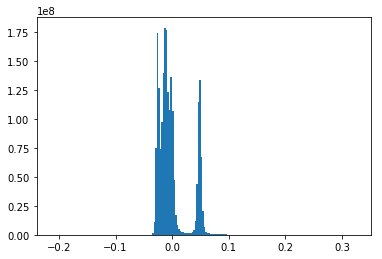

In [9]:
plt.hist(Image_RGB.reshape(-1,),200)

In [10]:
data = Image_RGB
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
print('train_data.shape:',train_data.shape)


train_data.shape: (100000, 64, 64, 5)


In [11]:
batch_size =100
latent_dim = 30
nb_epoch = 50
intermediate_dim =512
original_dim = 64*64
LRelu = keras.layers.advanced_activations.LeakyReLU(alpha=0.3)

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(input_img)
conv_1 = Activation(LRelu)(conv_1)
conv_1 = BatchNormalization()(conv_1)
maxpool_1 = MaxPooling2D((2, 2),padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), padding='same',kernel_initializer='normal')(maxpool_1)
conv_2 = Activation(LRelu)(conv_2)
conv_2 = BatchNormalization()(conv_2)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_2)
conv_3 = Activation(LRelu)(conv_3)
conv_3 = BatchNormalization()(conv_3)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3),padding='same',kernel_initializer='normal')(maxpool_3)
conv_4 = Activation(LRelu)(conv_4)
conv_4 = BatchNormalization()(conv_4)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_4)
h_1 = Dense(intermediate_dim, activation='relu')(visual)#relu?
encoded = Dense(latent_dim, activation='tanh')(h_1)# relu?


if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation=LRelu)(encoded)#for AE
    
    
h_4 = Dense(20*4*4,activation=LRelu)(h_3)
h_5 = Reshape((4,4,20))(h_4)


#conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

#conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_7 = UpSampling2D((2, 2))(h_5)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='relu',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')


#def vae_loss(x, decoded):  
#    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
#    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
#    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)

In [12]:
autoencoder.fit(train_data[:100000], train_data[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 169s - loss: 0.2153 - val_loss: 0.1644
Epoch 2/100
80000/80000 [==============================] - 161s - loss: 0.1346 - val_loss: 0.1167
Epoch 3/100
80000/80000 [==============================] - 161s - loss: 0.1191 - val_loss: 0.1116
Epoch 4/100
80000/80000 [==============================] - 161s - loss: 0.1101 - val_loss: 0.1044
Epoch 5/100
80000/80000 [==============================] - 161s - loss: 0.1047 - val_loss: 0.1053
Epoch 6/100
80000/80000 [==============================] - 161s - loss: 0.1013 - val_loss: 0.1055
Epoch 7/100
80000/80000 [==============================] - 161s - loss: 0.0982 - val_loss: 0.0951
Epoch 8/100
80000/80000 [==============================] - 161s - loss: 0.0967 - val_loss: 0.1044
Epoch 9/100
80000/80000 [==============================] - 161s - loss: 0.0948 - val_loss: 0.0893
Epoch 10/100
80000/80000 [==============================] - 161s - l

In [14]:
autoencoder.save_weights('hennanxunliande.h5')

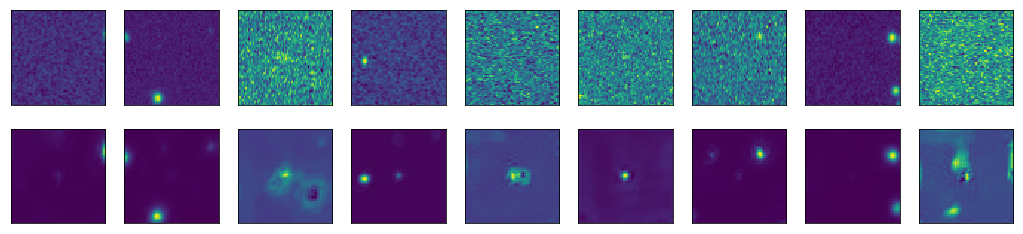

In [15]:
decoded_imgs = autoencoder.predict(train_data[0:100],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[0:100][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
encoder = Model(inputs=input_img, outputs=encoded)
encoded_variables = encoder.predict(train_data[:100000],batch_size=100)
encoded_variables.shape

(100000, 30)

In [17]:
Zero_one_normalized_encoded_variables = encoded_variables#/np.std(encoded_variables)/2

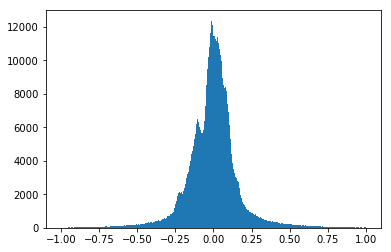

In [18]:
plt.hist(Zero_one_normalized_encoded_variables.reshape(-1,),2000)
plt.show()

In [19]:
Zero_one_normalized_encoded_variables.shape

(100000, 30)

# VAE

In [20]:
"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(1)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.3*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [21]:
vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - loss: 0.6567 - val_loss: 0.0880
Epoch 2/100
80000/80000 [==============================] - 3s - loss: 0.1904 - val_loss: 0.0669
Epoch 3/100
80000/80000 [==============================] - 3s - loss: 0.1785 - val_loss: 0.0659
Epoch 4/100
80000/80000 [==============================] - 3s - loss: 0.1752 - val_loss: 0.0619
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 0.1708 - val_loss: 0.0586
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 0.1686 - val_loss: 0.0577
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 0.1660 - val_loss: 0.0569
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 0.1654 - val_loss: 0.0545
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 0.1628 - val_loss: 0.0541
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 0.1629 - val_lo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


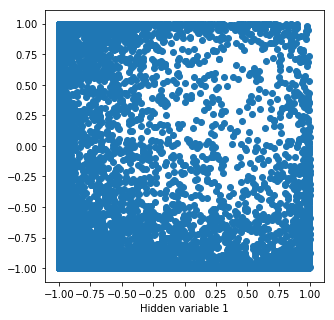

In [24]:
lower_lim = 0
upper_lim = 100000

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)


plt.figure(figsize=(5, 5))
plt.scatter(x_vis[:, 0] ,x_vis[:, 1])
plt.xlabel("Hidden variable 1")

plt.show()

In [28]:

"""VAE"""
net_3_input= Input(shape=(30,))
h_1 = Dense(30, activation='tanh')(net_3_input)

z_mean = Dense(2,activation='tanh')(h_1)
z_log_var = Dense(2)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(100, 2), mean=0.,stddev=0.1)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
decoded = Dense(30, activation='tanh')(z)


def vae_loss(x, decoded):
    xent_loss = K.sum((objectives.mse(x ,decoded)),axis=-1)
    #kl_loss_d1 = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    m = K.constant(0.7)
    s = K.constant(1)
    #kl_loss_d1 = K.sum(K.log(2/K.exp(z_log_var/2))+(K.square(z_mean)+(K.exp(z_log_var/2)-K.constant(1))*(K.exp(z_log_var/2)+K.constant(1)))/(K.constant(2)),axis = -1)
    kl_loss_d1 = K.sum(K.log(2*s/K.exp(z_log_var/2))+(K.constant(2)*m*(-K.exp(-(K.square(z_mean))/((K.constant(2))*K.exp(z_log_var)))*K.exp(z_log_var/2) + K.sqrt(K.constant(np.pi/2))*z_mean*(K.constant(1)-K.tanh(K.constant(1.19)*z_mean/K.constant(np.sqrt(2))/K.exp(z_log_var/2)))) )/(K.square(s))+(K.square(m-z_mean)+(K.exp(z_log_var/2)-s)*(K.exp(z_log_var/2)+s))/(K.constant(2)*K.square(s)),axis = -1)
    return 1*xent_loss + 0.005*kl_loss_d1 
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
vae = Model(input=net_3_input, output=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [29]:
vae.fit(Zero_one_normalized_encoded_variables[:100000], Zero_one_normalized_encoded_variables[:100000],
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_split=0.2,callbacks=[EarlyStopping])

Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 4s - loss: 2.2306 - val_loss: 1.9522
Epoch 2/100
80000/80000 [==============================] - 3s - loss: 2.0213 - val_loss: 1.8985
Epoch 3/100
80000/80000 [==============================] - 3s - loss: 1.9902 - val_loss: 1.8868
Epoch 4/100
80000/80000 [==============================] - 3s - loss: 1.9857 - val_loss: 1.8844
Epoch 5/100
80000/80000 [==============================] - 3s - loss: 1.9839 - val_loss: 1.8820
Epoch 6/100
80000/80000 [==============================] - 3s - loss: 1.9824 - val_loss: 1.8815
Epoch 7/100
80000/80000 [==============================] - 3s - loss: 1.9809 - val_loss: 1.8812
Epoch 8/100
80000/80000 [==============================] - 3s - loss: 1.9798 - val_loss: 1.8784
Epoch 9/100
80000/80000 [==============================] - 3s - loss: 1.9786 - val_loss: 1.8774
Epoch 10/100
80000/80000 [==============================] - 3s - loss: 1.9778 - val_lo

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


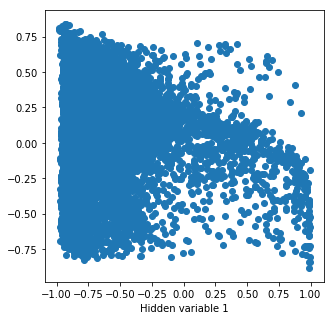

In [30]:
lower_lim = 0
upper_lim = 100000

vis = Model(input=net_3_input, output=z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(Zero_one_normalized_encoded_variables[lower_lim:upper_lim], batch_size=batch_size)


plt.figure(figsize=(5, 5))
plt.scatter(x_vis[:, 0] ,x_vis[:, 1])
plt.xlabel("Hidden variable 1")

plt.show()

In [45]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

test_Image = []
Class = []

for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        test_Image.append(a[j]['image'])
        Class.append(a[j]['class'])


test_Image = np.asarray(test_Image)
Class = np.asarray(Class)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [46]:
np.shape(test_Image)

(14142, 5, 64, 64)

In [47]:
test_Image_RGB = test_Image.transpose(0,2,3,1)

In [48]:
for i in range(len(test_Image_RGB)):
    if True in np.isnan(test_Image_RGB[i]).reshape(64*64*5):
        print(i)
        test_Image_RGB[i][np.isnan(test_Image_RGB[i])==True]=np.mean(test_Image_RGB[0])
#show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
#Image_RGB -= np.mean(Image_RGB)
#Image_RGB /= np.std((Image_RGB))


test_Image_RGB /= np.max(test_Image_RGB)
test_Image_RGB -= np.mean(test_Image_RGB)
test_Image_RGB = -test_Image_RGB

815


In [50]:
np.min(test_Image_RGB)

-0.071392298

In [51]:
test_encoded_variables = encoder.predict(test_Image_RGB[:10000],batch_size=100)

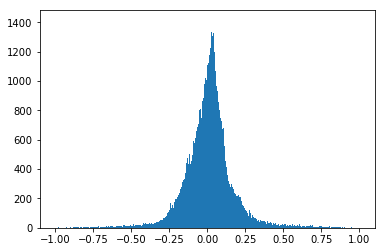

In [52]:
plt.hist(test_encoded_variables.reshape(-1,),2000)
plt.show()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


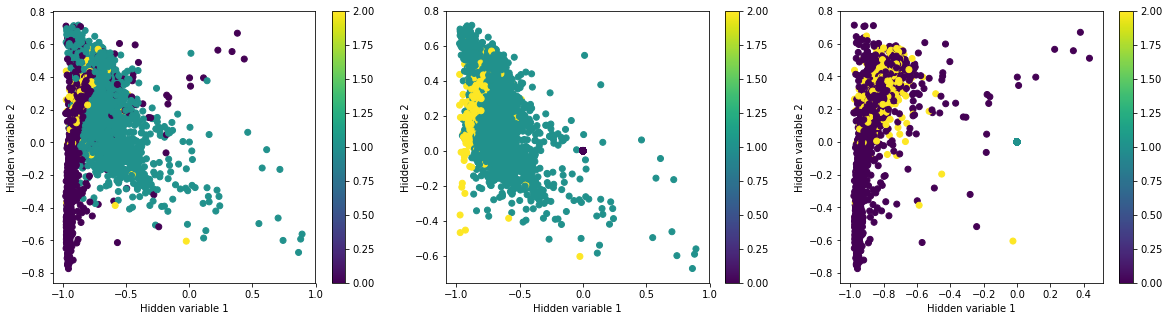

In [65]:
vis = Model(input=net_3_input, output=z_mean)
x_vis = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)

x_vis_1 = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)  
x_vis_1[Class[:10000]<1]=0

x_vis_2 = vis.predict(test_encoded_variables[:10000], batch_size=batch_size)  
x_vis_2[Class[:10000]==1]=0


plt.figure(figsize=(20, 5))

ax = plt.subplot(1,3,1)
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=Class[:10000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,2)
plt.scatter( x_vis_1[:, 0] ,x_vis_1[:, 1],c=Class[:10000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
ax = plt.subplot(1,3,3)
plt.scatter( x_vis_2[:, 0] ,x_vis_2[:, 1],c=Class[:10000])
plt.colorbar()
plt.xlabel("Hidden variable 1")
plt.ylabel("Hidden variable 2")
plt.show()
plt.show()

In [60]:
Class[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1])

In [68]:
upper_lim=10000

2200
AUC: 0.879109618387


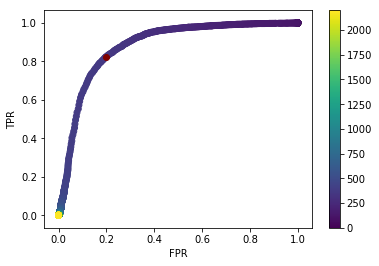

In [70]:
Y_pred = x_vis[:,0]
thr_min = -1.1
thr_max = 1.1
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class[lower_lim:upper_lim] ==0 ] = 0
TA[Class[lower_lim:upper_lim] ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)
    
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

print("AUC:",metrics.auc(FPR, TPR))